# Positional Encoding Applied To Time Stamps Dataset

In [1]:
import numpy as np
from utils import loadFile, encodeDataTimeStamps, insertTargetTimeStamps, positionalEncoding
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from silence_tensorflow import silence_tensorflow
silence_tensorflow()  # silence TF warnings
import tensorflow as tf

# Use Both Starts And Ends Time Stamps, Concatenate Them

In [2]:
### instantiate the tokenizer
tokenizer = AutoTokenizer.from_pretrained("jplu/tf-camembert-base", do_lower_case=True)

### punctuation encoder
punctuation_enc = {
    'SPACE': 0,
    'PERIOD': 1,
}
outputDimension = len(punctuation_enc)

### hyper-parameters
hiddenDimension = 768
batchSize = 6
sequenceSize = 16

In [3]:
### Get Training Dataset

trainDataName = './outFile_031.txt'
dataTrain = loadFile(trainDataName)

# encode data and insert target
XTrain, XTrainBeg, XTrainEnd, yTrain = encodeDataTimeStamps(dataTrain, tokenizer, punctuation_enc)
XTrainMod, XTrainBegMod, XTrainEndMod = insertTargetTimeStamps(XTrain, XTrainBeg, XTrainEnd, sequenceSize)
yTrain = np.asarray(yTrain)

XTrainAll = np.stack((XTrainMod, XTrainBegMod, XTrainEndMod), axis = 2)

### Build The Dataset
trainDataset = tf.data.Dataset.from_tensor_slices((XTrainAll, yTrain)).batch(batchSize)

print("\nTraining Dataset Tensor Shape = ", XTrainAll.shape)


Training Dataset Tensor Shape =  (665, 16, 3)


In [4]:
X, y = next(iter(trainDataset))
print(X.shape)
print("")
tokens = tf.cast(X[:, :, 0], dtype="int64")
starts = X[:, :, 1]
ends = X[:, :, 2]
print(type(starts), starts.shape)

(6, 16, 3)

<class 'tensorflow.python.framework.ops.EagerTensor'> (6, 16)


In [5]:
### Apply Positional Encoding To Starts Time Stamps

depth = hiddenDimension//2
startsEnc = positionalEncoding(starts, depth)
print(type(startsEnc), "    ", startsEnc.shape)

<class 'numpy.ndarray'>      (6, 16, 384)


In [6]:
print(starts[5, :])

tf.Tensor(
[0.   0.07 0.31 0.45 0.7  0.85 1.04 1.04 1.16 1.48 1.6  2.26 2.26 2.26
 3.09 3.14], shape=(16,), dtype=float64)


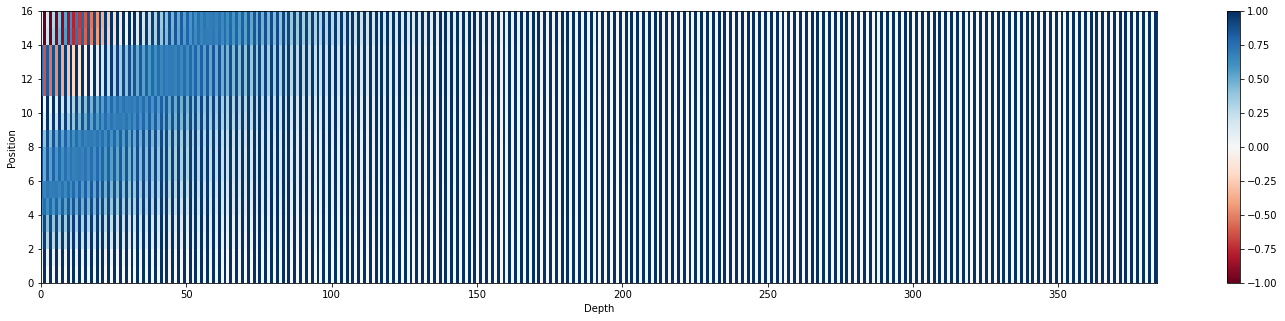

In [7]:
plt.figure(figsize=(25,5))
plt.pcolormesh(startsEnc[5, :, :], cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()
plt.show()

In [8]:
### Apply Positional Encoding To End Time Stamps

endsEnc = positionalEncoding(ends, depth)

(6, 16, 768)


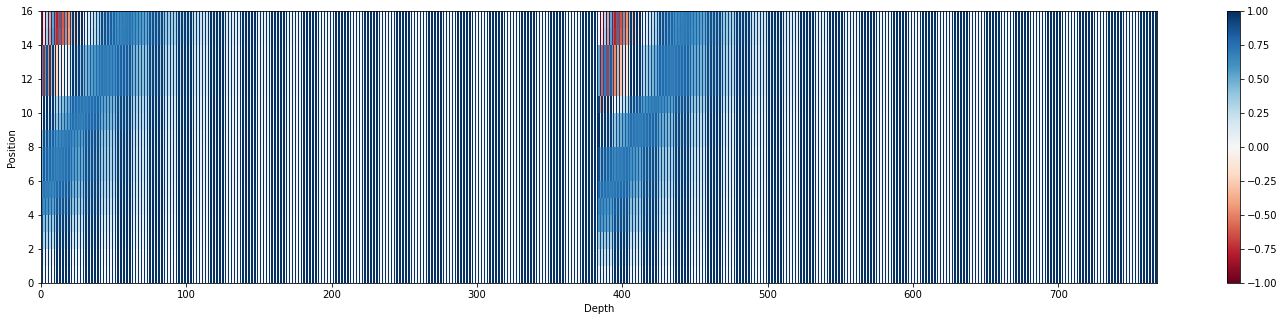

In [13]:
### Concatenate The Two And Plot

allEnc = np.concatenate((startsEnc, endsEnc), axis=2)
print(allEnc.shape)

plt.figure(figsize=(25,5))
plt.pcolormesh(allEnc[5, :, :], cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0, allEnc.shape[2]])
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()
plt.show()